In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

import os

from bcnf.utils import get_gaussian_kernel, partconv1d, get_dir

In [2]:
wandb.login()

api = wandb.Api()
runs = {
    'trajectory_FC_large': api.run("/balisticcnf/bcnf-test/runs/v83m23td"),
    'trajectory_LSTM_large': api.run("/balisticcnf/bcnf-test/runs/eu00x1d2"),
    'trajectory_TRF_large': api.run("/balisticcnf/bcnf-test/runs/hnj6npt2"),
    'trajectory_FC_small': api.run("/balisticcnf/bcnf-test/runs/xfkfo69v"),
    'trajectory_LSTM_small': api.run("/balisticcnf/bcnf-test/runs/1qwwz99a"),
    'trajectory_TRF_small': api.run("/balisticcnf/bcnf-test/runs/m8fqmi3n"),
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: psaegert (bcnf). Use `wandb login --relogin` to force relogin


In [3]:
histories = {k: v.history() for k, v in runs.items()}

In [4]:
histories['trajectory_TRF_small'].keys()

Index(['distance_to_last_best_val_loss_fold_-1', '_timestamp',
       'train_loss_fold_-1', 'z_mean_std_fold_-1', 'z_std_mean_fold_-1',
       'epoch', 'time_fold_-1', 'z_std_std_fold_-1', 'z_mean_mean_fold_-1',
       '_step', 'val_loss_fold_-1', '_runtime', 'lr_fold_-1'],
      dtype='object')

In [5]:
def format_epoch(epoch: int) -> str:
    if epoch < 10000:
        return str(epoch)
    elif epoch < 1_000_000:
        return f"{epoch // 1000}k"

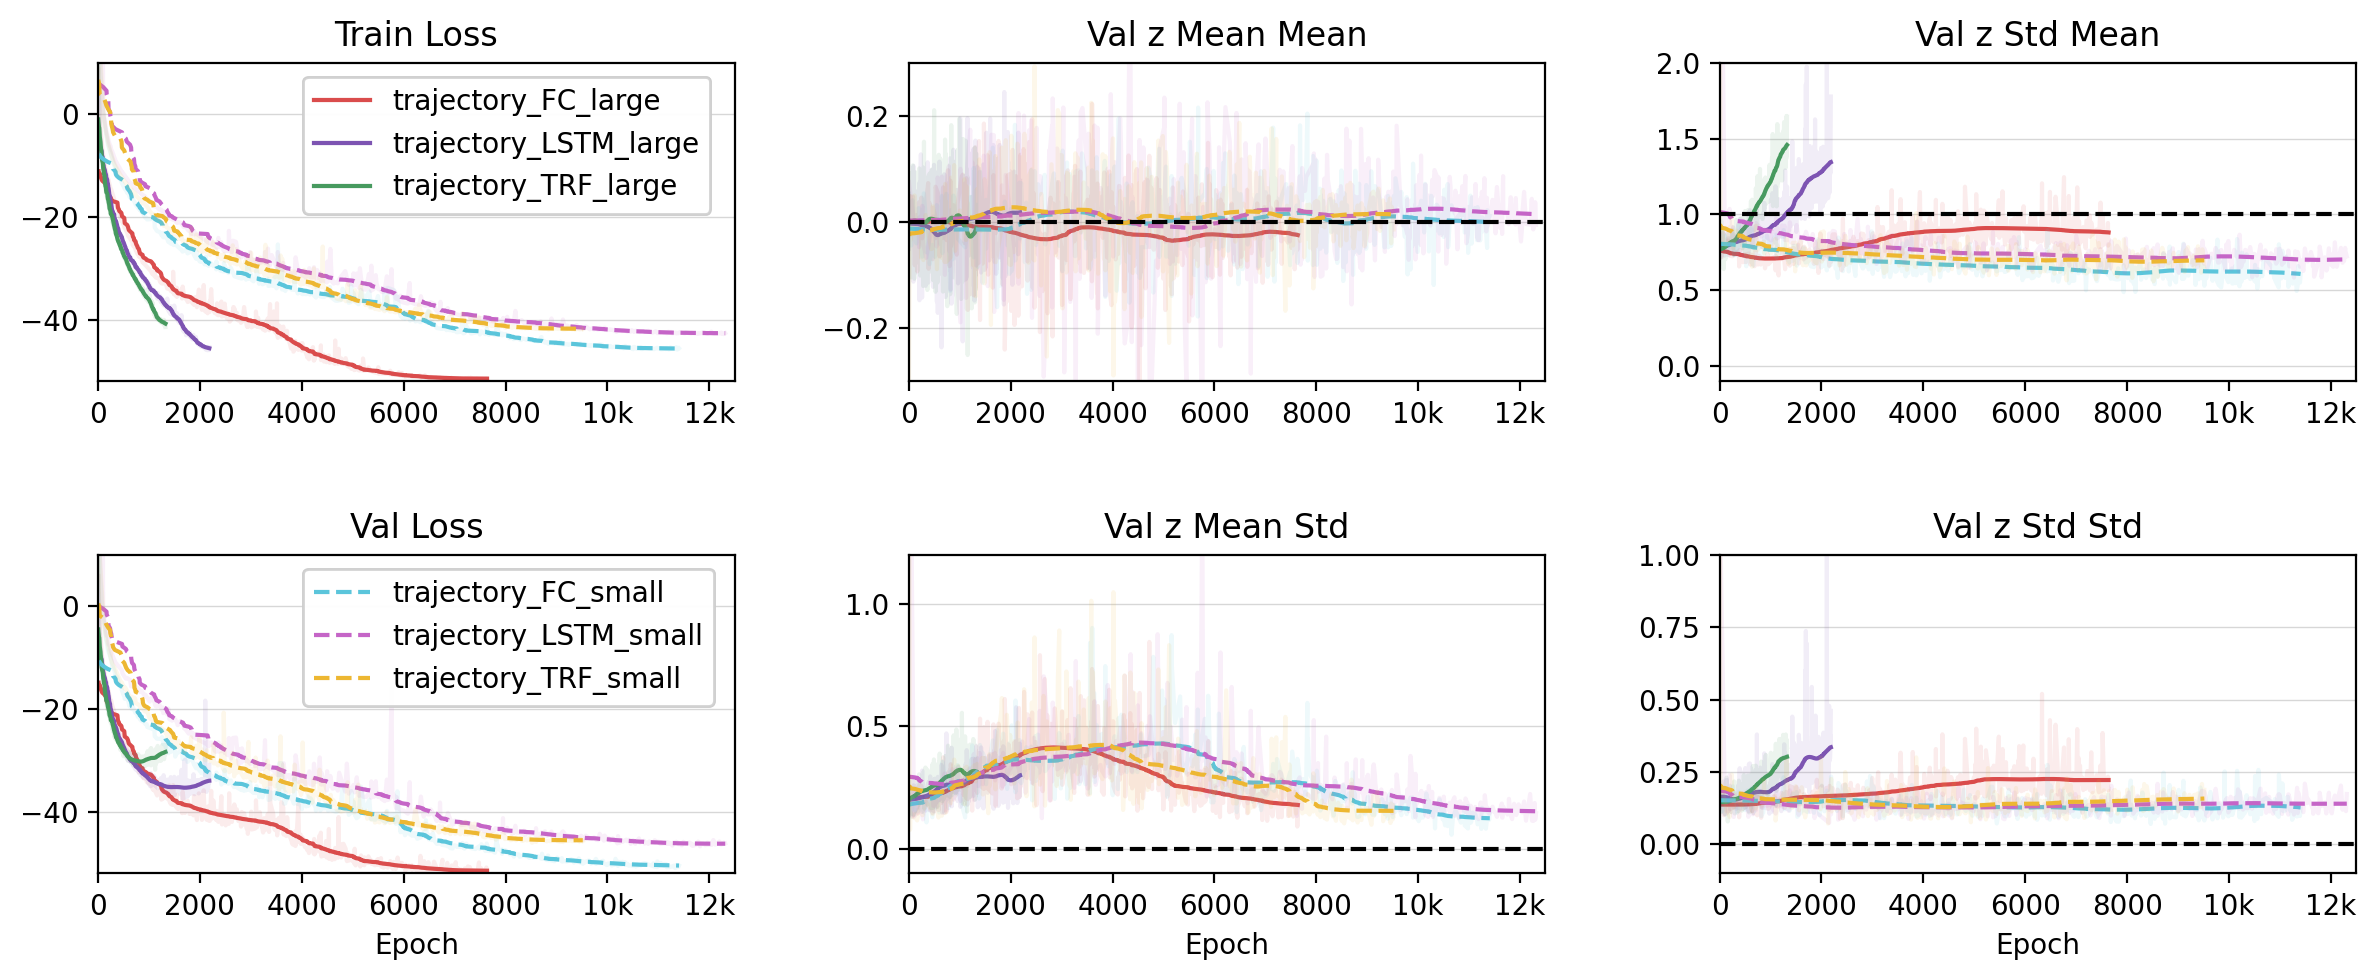

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), dpi=200)

for i, (ax, key, key_name, target, ylim) in enumerate(
    zip(axes.flatten(),
        ['train_loss_fold_-1', 'z_mean_mean_fold_-1', 'z_std_mean_fold_-1', 'val_loss_fold_-1', 'z_mean_std_fold_-1', 'z_std_std_fold_-1'],
        ['Train Loss', 'Val z Mean Mean', 'Val z Std Mean', 'Val Loss', 'Val z Mean Std', 'Val z Std Std'],
        [None, 0, 1, None, 0, 0],
        [(-52, 10), (-.3, .3), (-.1, 2), (-52, 10), (-.1, 1.2), (-.1, 1)]
        )):
    for (name, history), color, linestyle in zip(
        histories.items(),
        # ['7d54b2', '479a5f', 'da4c4c', 'a46750', '5bc5db', 'edb732'],
        ['da4c4c', '7d54b2', '479a5f', '5bc5db', 'c565c7', 'edb732'],
        ['-', '-', '-', '--', '--', '--']):
        ax.plot(history['epoch'], history[key], alpha=0.1, color='#' + color)
        ax.plot(history['epoch'], partconv1d(data=np.array(history[key]), kernel=get_gaussian_kernel(20)), label=name, color='#' + color, linestyle=linestyle)

        ax.set_xlim(0, 12500)
        ax.set_xticks(np.arange(0, 14_000, 2_000))
        ax.set_xticklabels([format_epoch(x) for x in np.arange(0, 14_000, 2_000)])

    ax.set_ylim(ylim)

    if target is not None:
        ax.axhline(target, color='black', linestyle='--')
    ax.set_title(key_name)
    ax.grid(axis='y', alpha=0.5, linewidth=0.5)

    if i in [3, 4, 5]:
        ax.set_xlabel('Epoch')

# Split the legend into two parts
handles, labels = ax.get_legend_handles_labels()
legend1 = axes[0, 0].legend(handles[:3], labels[:3], loc='upper left', bbox_to_anchor=(0.3, 1))
legend2 = axes[1, 0].legend(handles[3:], labels[3:], loc='upper left', bbox_to_anchor=(0.3, 1))
axes[0, 0].add_artist(legend1)
axes[1, 0].add_artist(legend2)

fig.tight_layout(h_pad=3, w_pad=3)

plt.savefig(os.path.join(get_dir('results', 'logging', create=True), 'train_trajectory_comparison.png'))

In [7]:
losses = {name: pd.DataFrame(history).tail(1)[['train_loss_fold_-1', 'val_loss_fold_-1']] for name, history in histories.items()}

results_df = pd.concat(losses, axis=0)

results_df.round(2)

,,train_loss_fold_-1,val_loss_fold_-1
trajectory_FC_large,499,-51.60,-51.94
trajectory_LSTM_large,499,-45.35,-30.88
trajectory_TRF_large,499,-41.44,-26.99
trajectory_FC_small,499,-45.58,-50.46
trajectory_LSTM_small,499,-42.64,-46.17
trajectory_TRF_small,499,-41.85,-45.70
